# Finetune ResNet50

With 1000 x 400 melspectrogram images and data augmentation (artificial noise addition with Gaussian noise)


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image

Set some constant strings


In [2]:
FINETUNED_MODEL = 'resnet50_augmented'

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Custom dataset class for loading mel spectrogram images


In [4]:
# Custom dataset class for loading Melspectrograms
class MelSpectrogramDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with Melspectrogram paths and labels.
            root_dir (string): Directory with all the Melspectrograms.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        df = pd.read_csv(csv_file)  # Read the CSV into a DataFrame
        self.data_frame = df[['Melspectrogrampath', 'Emotion']]
        self.root_dir = root_dir
        self.transform = transform

        # Sort unique labels before mapping
        unique_labels = sorted(df['Emotion'].unique())
        self.label_map = {label: idx for idx,
                          label in enumerate(unique_labels)}

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        # Get the path to the Melspectrogram and the emotion label (string)
        # First column is path, second column is label (emotion as string)
        mel_path = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])
        emotion_label_str = self.data_frame.iloc[idx, 1]

        # Convert the emotion string to its corresponding integer
        emotion_label = self.label_map[emotion_label_str]

        # Load the Melspectrogram
        mel_image = Image.open(mel_path)
        mel_image = mel_image.convert("RGB")

        # Apply transformations if any
        if self.transform:
            mel_image = self.transform(mel_image)

        # Convert emotion label to tensor
        emotion_label = torch.tensor(emotion_label, dtype=torch.long)

        return mel_image, emotion_label

Define the training function


In [5]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the testing/evaluation function


In [6]:
def test(model, testloader, criterion, device):
    test_loss = 0.0
    test_total = 0
    test_correct = 0

    # Switch to evaluation mode
    model.eval()

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            test_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss = test_loss / len(testloader)
    test_accuracy = test_correct / test_total * 100

    return test_loss, test_accuracy

Define what happens in each epoch


In [7]:
def train_epochs(model, trainloader, testloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    best_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        test_loss, test_accuracy = test(model, testloader, criterion, device)
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(f'Test Loss: {test_loss} - Test Accuracy: {test_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # Check if current model is best performing using test_accuracy
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save(model.state_dict(), f'best_{FINETUNED_MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'test_losses': test_losses,
                'test_accuracies': test_accuracies,
            }
            torch.save(checkpoint, f'best_{FINETUNED_MODEL}_checkpoint.pt')

    return model, train_losses, train_accuracies, test_losses, test_accuracies

Plot the loss and accuracy graphs


In [8]:
def plot_loss(train_losses, test_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(test_losses)), test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [9]:
def plot_accuracy(train_accuracies, test_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(test_accuracies)),
             test_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Define a class to add Gaussian noise to the mel spectrogram images for onlien data augmentation


In [10]:
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std_range=(0.0, 0.1)):
        """
        Args:
            mean (float): Mean of the Gaussian noise.
            std_range (tuple): Range (min, max) from which to sample the noise std.
        """
        self.mean = mean
        self.std_range = std_range

    def __call__(self, tensor):
        # Sample a random standard deviation for this call
        std = random.uniform(self.std_range[0], self.std_range[1])
        noise = torch.randn(tensor.size()) * std + self.mean
        return tensor + noise

    def __repr__(self):
        return f'{self.__class__.__name__}(mean={self.mean}, std_range={self.std_range})'

Define model, learning rate, optimizer, transformations, criterion and number of epochs


In [11]:
model = models.resnet50(pretrained=True)

learning_rate = 0.001

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

criterion = nn.CrossEntropyLoss()

# Define train transformations, also the online data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the Mel spectrogram to 448x448
    transforms.ToTensor(),          # Convert to Tensor
    AddGaussianNoise(mean=0.0, std_range=(0.0, 0.1)
                     ),  # Online noise augmentation
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

# Define test transformations
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the Mel spectrogram to 448x448
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

epochs = 25

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


View pre-trained model architecture


In [12]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Execute the fine-tuning


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/25
Train Loss: 2.26305010952527 - Train Accuracy: 9.901264370090425
Test Loss: 2.2991173484108667 - Test Accuracy: 12.56826276216858

Epoch 2/25
Train Loss: 2.2648355067530765 - Train Accuracy: 9.558954470804725
Test Loss: 2.2959692044691606 - Test Accuracy: 13.288484368816778

Epoch 3/25
Train Loss: 2.263494583323032 - Train Accuracy: 9.69746136646946
Test Loss: 2.2990583265670623 - Test Accuracy: 12.995647012267511

Epoch 4/25
Train Loss: 2.2640788712079014 - Train Accuracy: 9.661845307584242
Test Loss: 2.295748582994095 - Test Accuracy: 13.074792243767314

Epoch 5/25
Train Loss: 2.2633760530737383 - Train Accuracy: 9.669759987336512
Test Loss: 2.2952771909309155 - Test Accuracy: 13.359715077166602

Epoch 6/25
Train Loss: 2.2639368914350677 - Train Accuracy: 9.851797621638735
Test Loss: 2.2966997984683877 - Tes

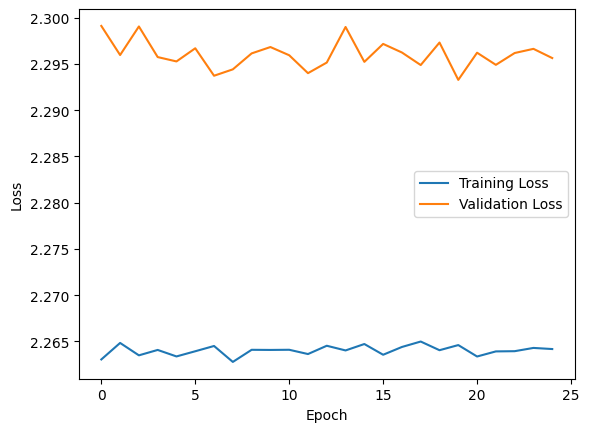

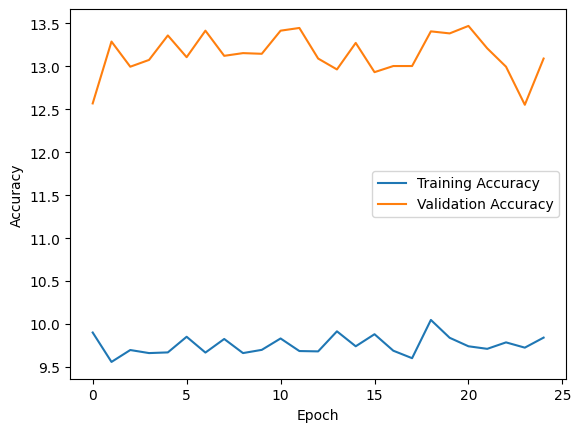

In [13]:
# Set random seed for reproducability
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

# Number of classes
num_classes = 9

# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify final fully connected layer according to number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
# print("Modified model")
# print(model)

# Unfreeze the final fully connected layer so it will be trained
for param in model.fc.parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load dataset
train_csv = '../../data/melspectrogram_train_dataset.csv'
test_csv = '../../data/melspectrogram_test_dataset.csv'
root_dir = '../../data/'

trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=train_transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=test_transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

# Training
print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, test_losses, test_accuracies = train_epochs(
    model, trainloader, testloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{FINETUNED_MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, test_losses)
plot_accuracy(train_accuracies, test_accuracies)